In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 28

EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[1: -3]
EVENTS_TO_CONSIDER = EVENTS[1: -3]

# **Polynomial Trajectories**

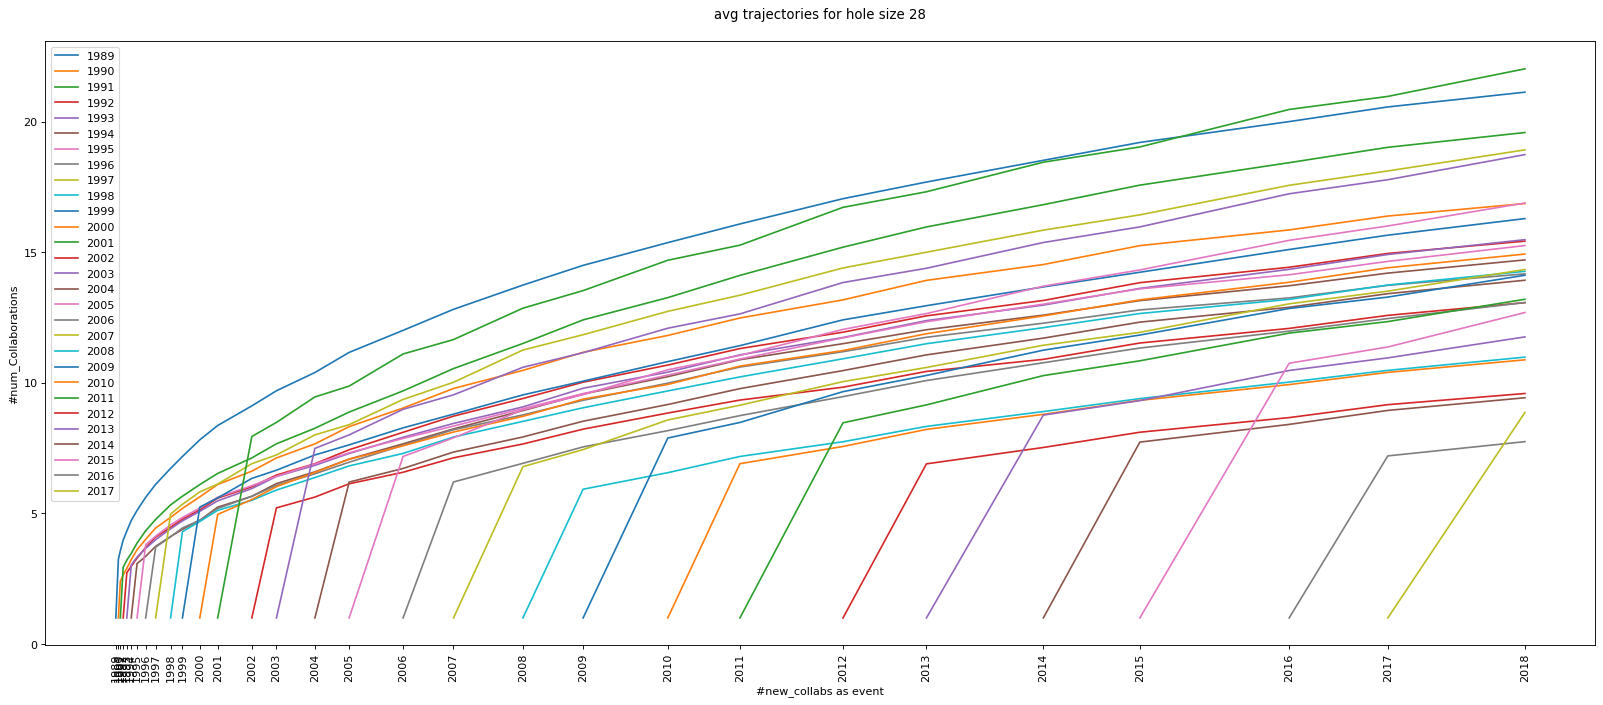

In [3]:
## Plot average trajectories 
plt.figure(figsize=(25, 10), dpi=80)
plt.title("avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(EVENTS, YEARS)
plt.show()

# **(2) Plotting fitting function**

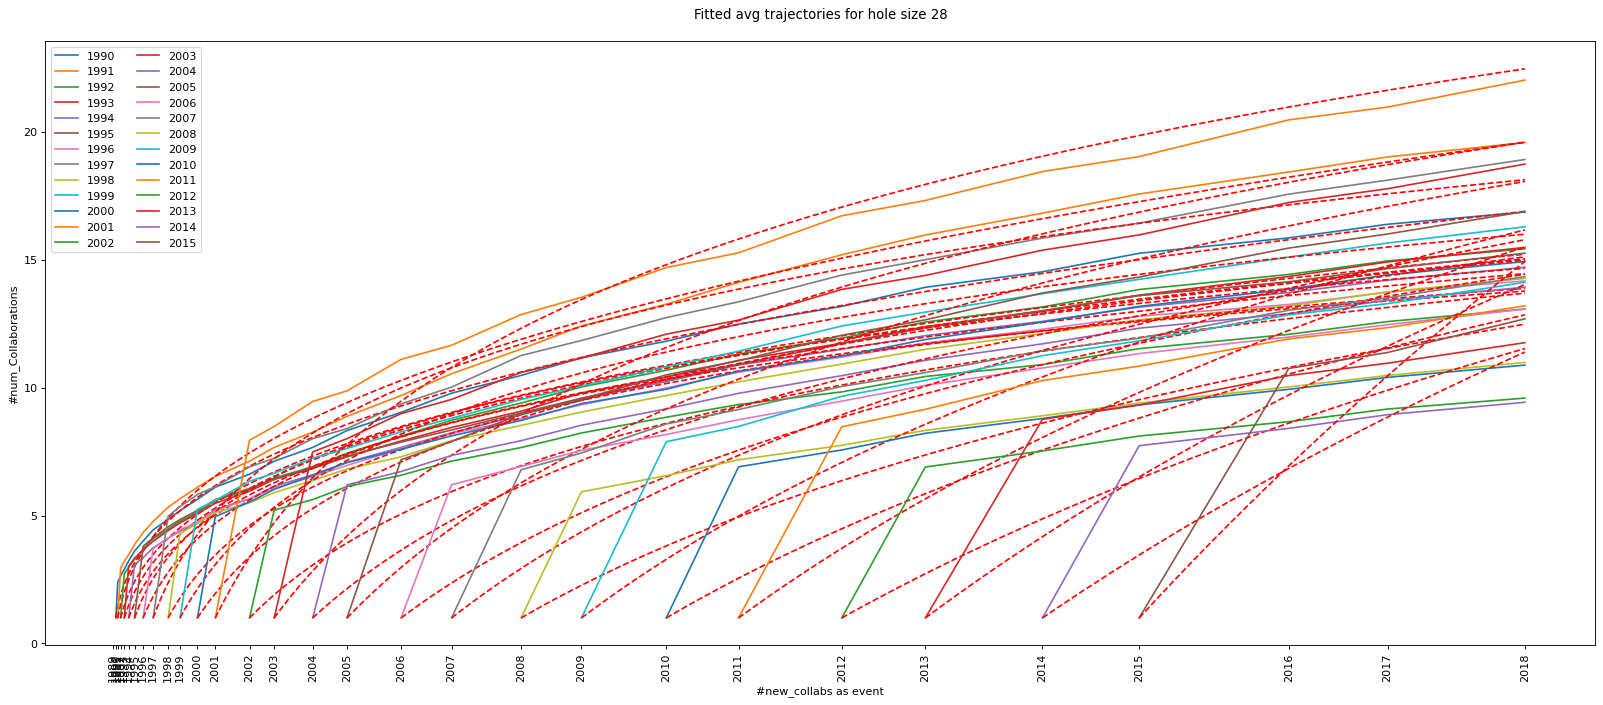

In [7]:
## Plot fitted average trajectories
plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []
for start_y in YEARS_TO_CONSIDER:
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size)     
    fit_y, alpha, beta = poly_fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
    
    xdata = [a for a in range(x[0], x[-1])]
    fit_y = poly_theoretical_func(xdata, alpha, beta, x[0])

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
    
    plt.plot(x,y, label=str(start_y))
    plt.plot(xdata, fit_y, 'r--')
    

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=2)
plt.xticks(EVENTS, YEARS)
plt.show()

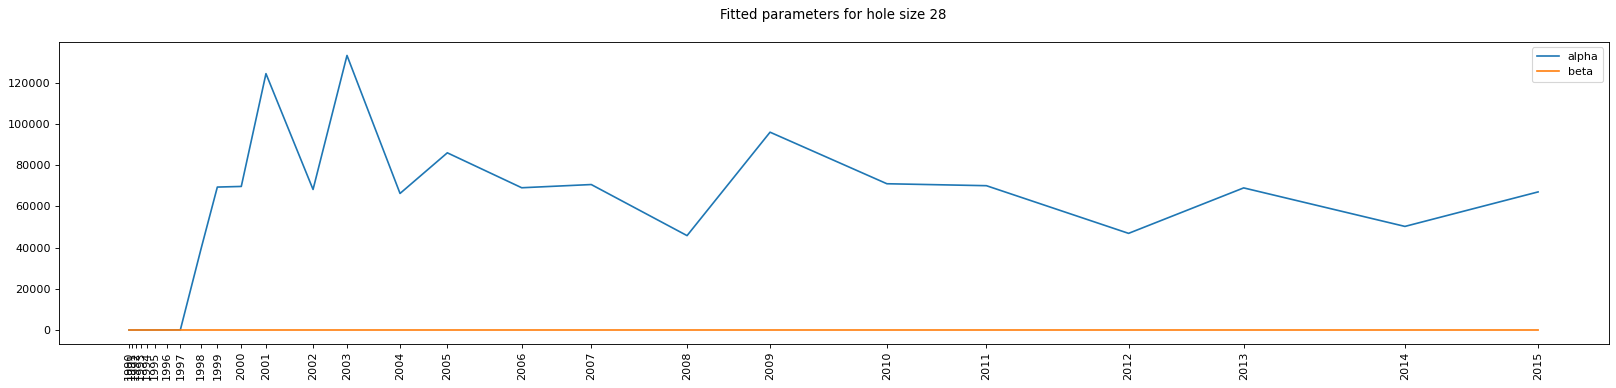

   start_y          alpha      beta
0     1990       0.981497  0.348505
1     1991       1.641522  0.362846
2     1992       2.901341  0.292187
3     1993       4.295349  0.266796
4     1994       6.487326  0.227788
5     1995      14.225492  0.152696
6     1996      39.081711  0.071781
7     1997      63.072452  0.066421
8     1998   39261.850137  0.000101
9     1999   69347.764651  0.000071
10    2000   69654.607838  0.000071
11    2001  124384.265591  0.000066
12    2002   68185.631708  0.000080
13    2003  133212.909005  0.000064
14    2004   66252.780370  0.000109
15    2005   85966.521101  0.000110
16    2006   69015.582190  0.000122
17    2007   70576.271259  0.000147
18    2008   45795.003932  0.000202
19    2009   95975.921465  0.000143
20    2010   70961.843746  0.000178
21    2011   70016.611593  0.000254
22    2012   46888.464509  0.000339
23    2013   68947.009069  0.000342
24    2014   50260.515912  0.000494
25    2015   66996.043338  0.000652


In [5]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.plot(EVENTS_TO_CONSIDER, alphas, label="alpha")
plt.plot(EVENTS_TO_CONSIDER, betas, label="beta")
plt.xticks(EVENTS_TO_CONSIDER, YEARS_TO_CONSIDER)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS_TO_CONSIDER[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors**

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

#### A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
#### B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

#### C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
#### D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [5]:
##### ERRORS FUNCTIONS FOR AVERAGE TRAJECTORIES #####

YEARS = get_str_years_event()

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
            err += pow(abs(poly_theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)

    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_B(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        
        tmp = []
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
        
            tmp.append(pow(abs(poly_theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2))
        err += np.max(tmp)
    
    sys.stdout.write('\r'+ "optimizing B function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = poly_fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        

        for e in events_subset:
            if(e>curr_x):
                err += pow(abs(poly_theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - poly_theoretical_func(e, alpha, beta, xdata[i])), 2)

    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_D(params, xdata, hole_size, years_to_consider=YEARS):
    
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        curr_x = xdata[i]  

        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = poly_fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 

        tmp = []
        for e in events_subset:
            if(e>curr_x):
                tmp.append(pow(abs(poly_theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - poly_theoretical_func(e, alpha, beta, xdata[i])), 2))
             
        if((len(tmp))!=0):
            err += np.max(tmp)
        
    sys.stdout.write('\r'+ "optimizing D function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

In [6]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]
bnds = ((0, None), (0, 0.9))

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 
result_A = minimize(err_f_A, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_B = minimize(err_f_B, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()


result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_D = minimize(err_f_D, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

'''                 ERROR        alpha      beta
err_f_A    8629.259328  2322.274298  0.001335
err_f_B    1154.668869  1831.248852  0.002059
err_f_C  114033.347350  3176.657893  0.001073
err_f_D    1572.802749  2267.860568  0.001783
'''

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))


optimizing A function with -> params: [2.3222743e+03 1.3348183e-03], error: 8629.259327781541258
optimizing B function with -> params: [1.83124885e+03 2.05919817e-03], error: 1154.6688694311767
optimizing C function with 200 events -> params: [3.17665789e+03 1.07292339e-03], error: 114033.34735043427
optimizing D function with 200 events -> params: [2.26786057e+03 1.78313576e-03], error: 1572.8027490866314

                 ERROR        alpha      beta
err_f_A    8629.259328  2322.274298  0.001335
err_f_B    1154.668869  1831.248852  0.002059
err_f_C  114033.347350  3176.657893  0.001073
err_f_D    1572.802749  2267.860568  0.001783


In [3]:
alphas_opt,betas_opt, errs = [2322.274298, 1831.248852, 3176.657893, 2267.860568], [0.001335, 0.002059, 0.001073, 0.001783], [8629.259328, 1154.668869, 114033.347350, 1572.802749]

# **(4) Shift fitted trajectories, compute their average and fit it**

In [8]:
# Shift all fitted trajectories
shifted_funcs = []

i = 0
for i in range(len(alphas)):
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER[i])

    xdata = [e+x[0] for e in ALL_EVENTS]        
    f = poly_theoretical_func(xdata, alphas[i], betas[i], x[0])
    
    shifted_funcs.append(f) # add function to the set
    i+=1
    
# compute the average of the shifted functions
avg_shift = np.average(np.array(shifted_funcs), axis=0)

In [9]:
# fit the average curve
fit_avg_shift , alpha, beta = poly_fit_trajectory(ALL_EVENTS, avg_shift) 

print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 6.22850523743697e-13 
 beta*: 0.183139392277849


In [4]:
alpha, beta = 6.22850523743697e-13, 0.183139392277849
fit_avg_shift = poly_theoretical_func(ALL_EVENTS, alpha, beta, np.int64(1))

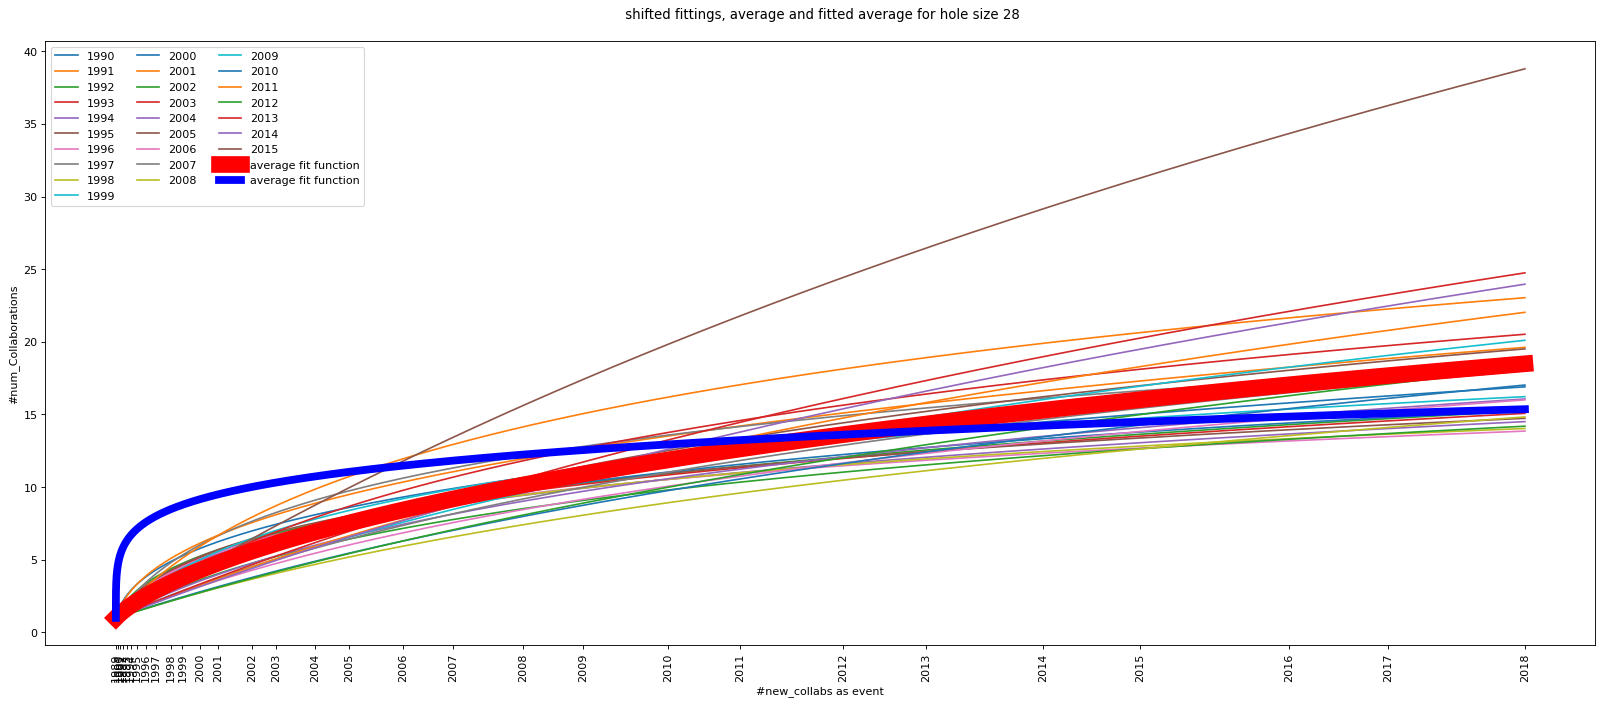

In [11]:
# plot shifted fitted tejectories, their average and it's fitting
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

j = 0
for start_y in YEARS_TO_CONSIDER:
    plt.plot(ALL_EVENTS,shifted_funcs[j], label=start_y)
    j = j+1  
          
plt.plot(ALL_EVENTS, avg_shift, 'r-+', label="average fit function",  linewidth=15.0)
plt.plot(ALL_EVENTS, fit_avg_shift, 'b-', label="average fit function", linewidth=7.0)
   
plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(EVENTS, YEARS)
plt.show()

In [12]:
# Error between the fitted average and all the other curves  
size = 200 # subset of events to consider 
n = (len(ALL_EVENTS))//size
    
events_subset = [ALL_EVENTS[e] for e in range(len(ALL_EVENTS)) if e%n==0][:size]

err = 0
for j in range(len(shifted_funcs)):      
    for e in events_subset:
        err += pow(abs(shifted_funcs[j][e] - fit_avg_shift[e]), 2)

print("Error between the fitted average and all the other shifted fittings is", err)

Error between the fitted average and all the other shifted fittings is 82921.99098188561


# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

### Error fitted trajectories

In [5]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = poly_theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    error_fit_functions[error_f_labels[i]] = functions_by_start_y

### Average fitted trajectories

In [6]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS_TO_CONSIDER:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    xdata = [e-x[0] for e in range(x[0],x[-1])]
    
    general_fit_y = poly_theoretical_func(xdata, alpha, beta, np.int64(1))
    average_fit_functions.append(general_fit_y)

### **plot everything**

In [7]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
def plot_all(start_y):
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    plt.plot(x,y, label="real data")

    xdata = [e for e in range(x[0],x[-1])]

    for i in range(len(error_f_labels)):
        err_f = error_fit_functions[error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ error_f_labels[i])

    plt.plot(xdata, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')    
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()

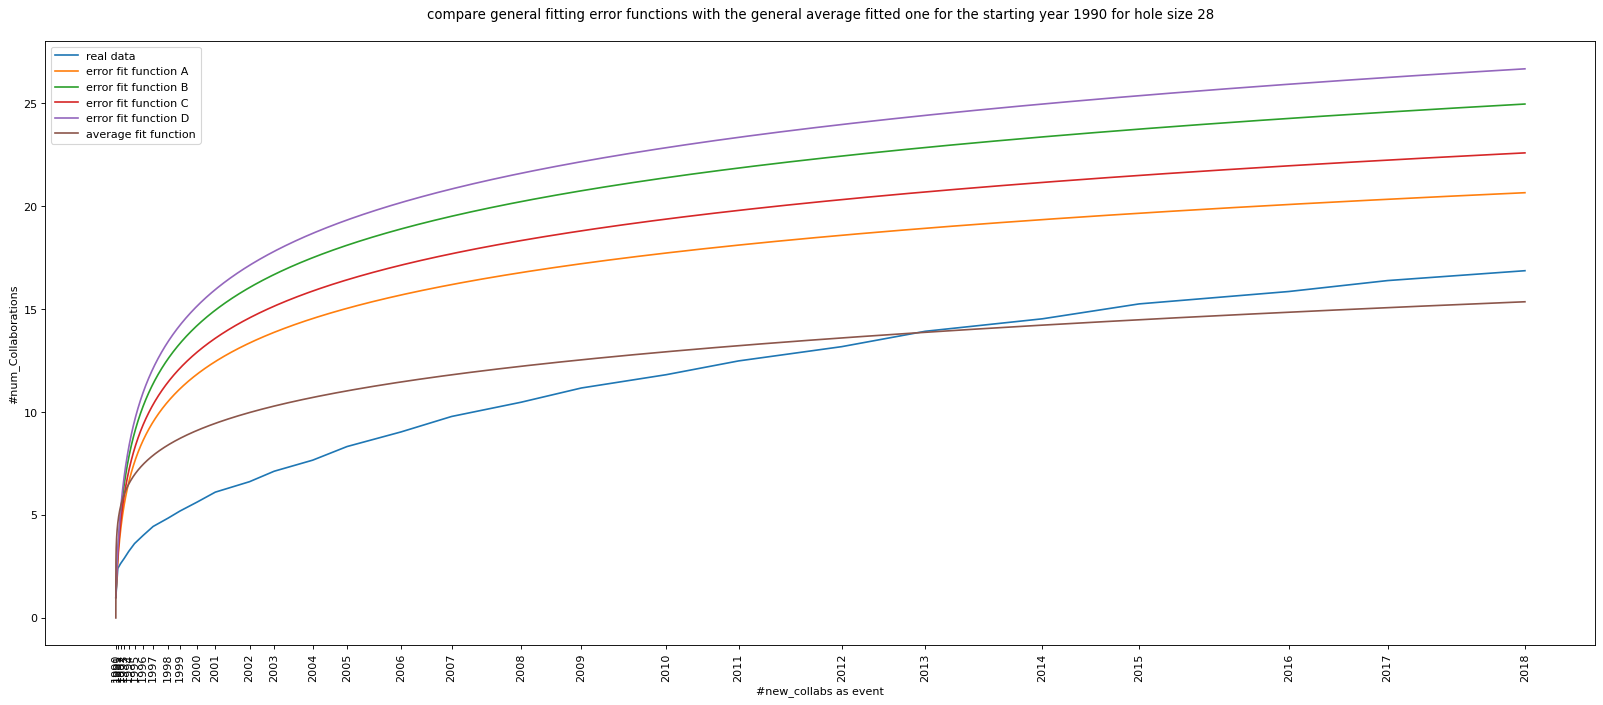

In [8]:
plot_all("1990")

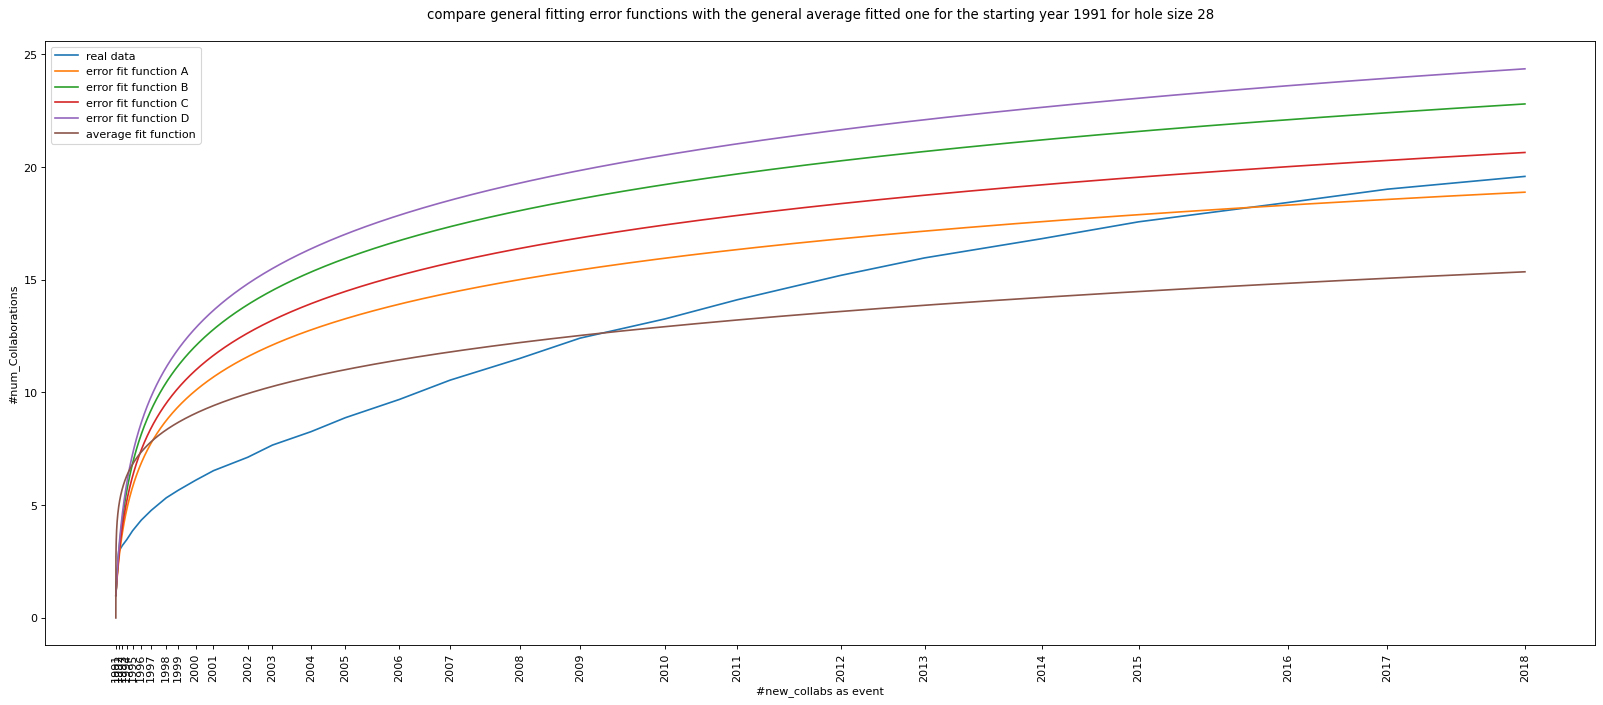

In [9]:
plot_all("1991")

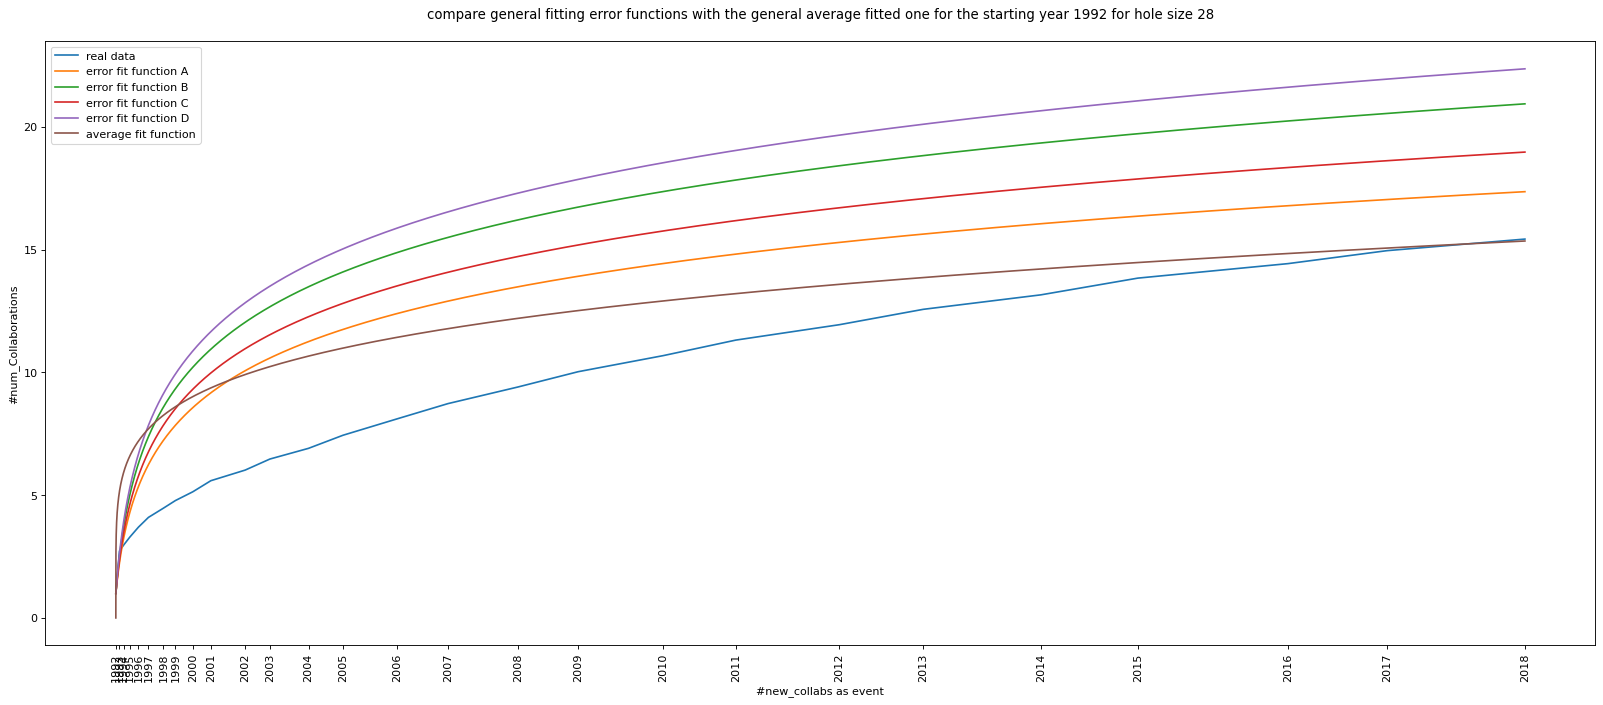

In [10]:
plot_all("1992")

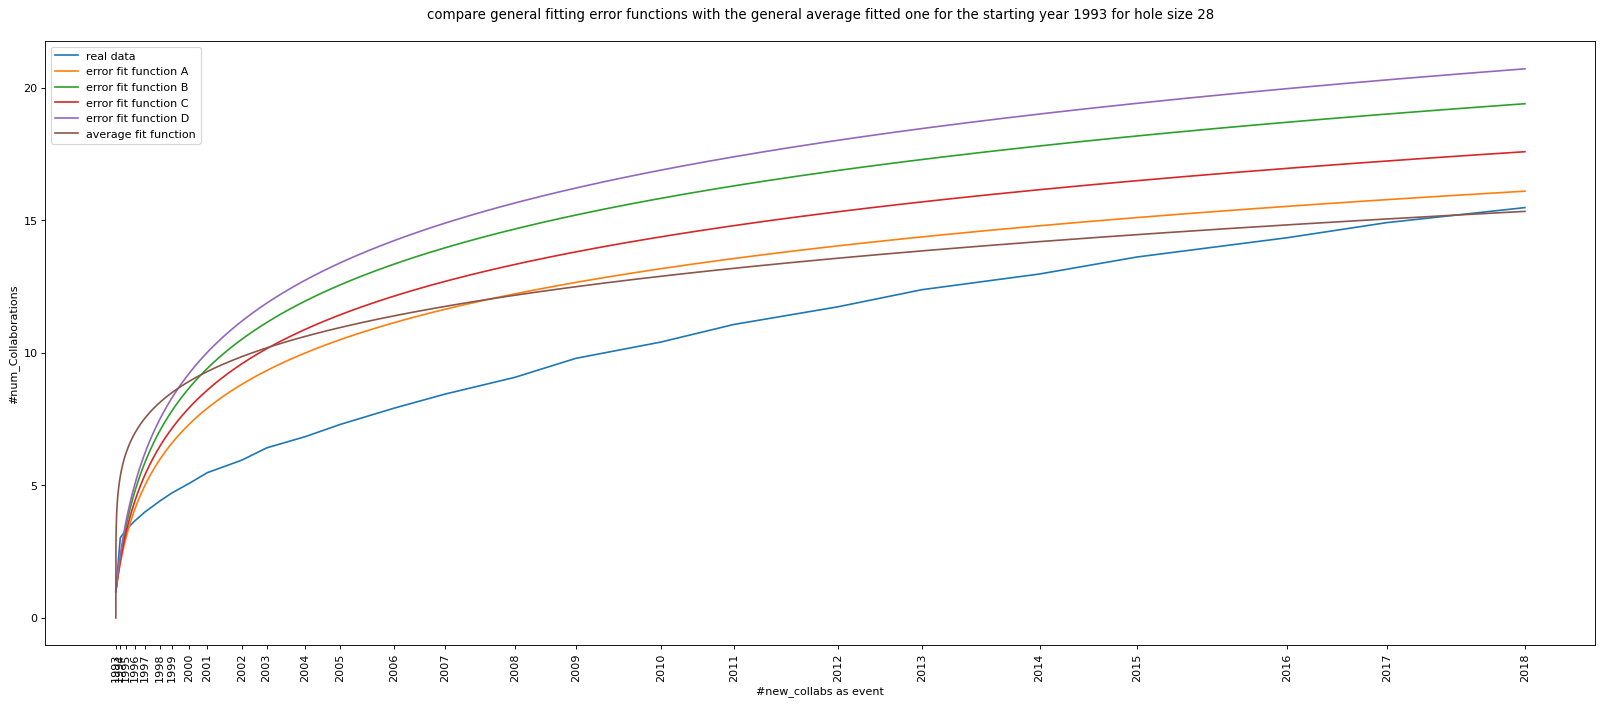

In [11]:
plot_all("1993")

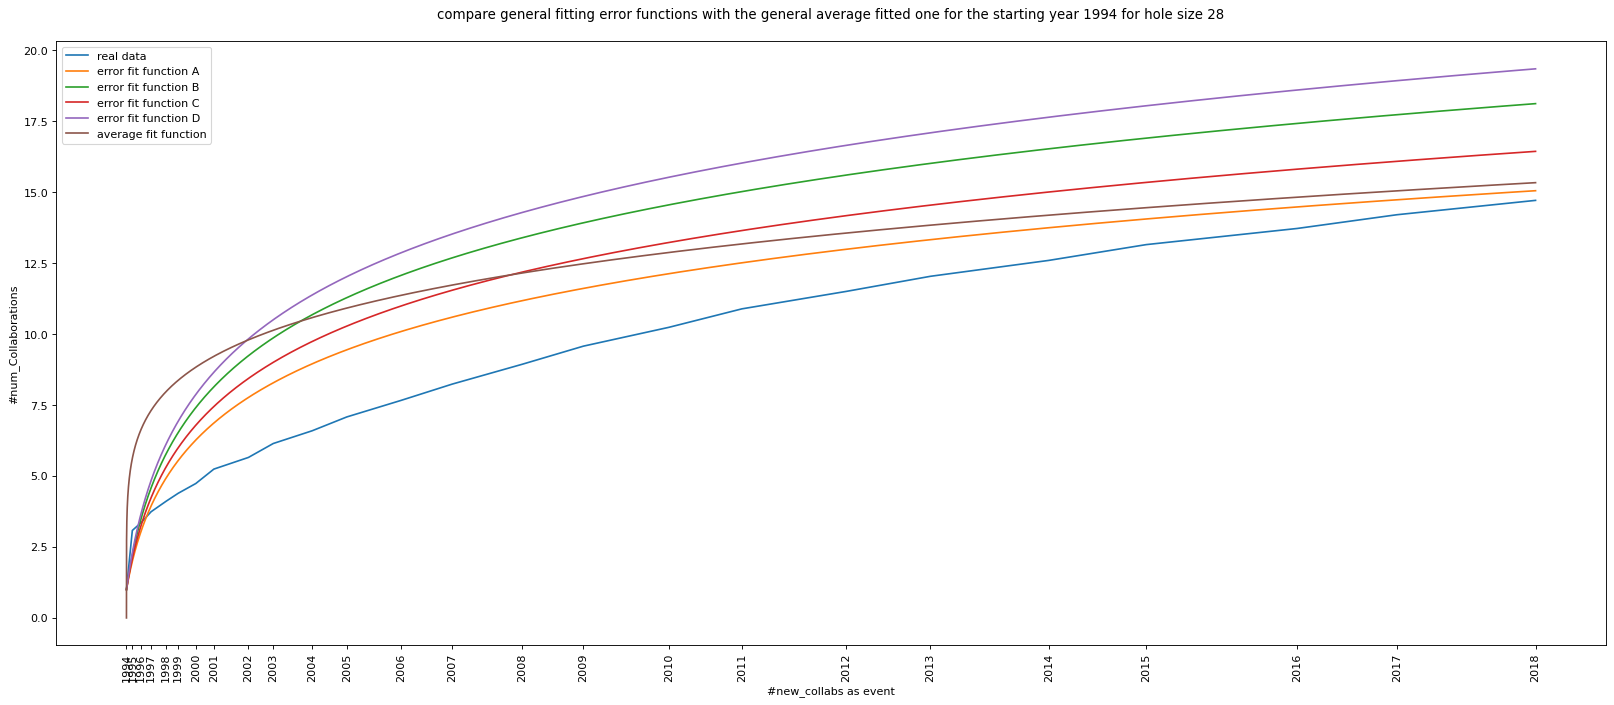

In [12]:
plot_all("1994")

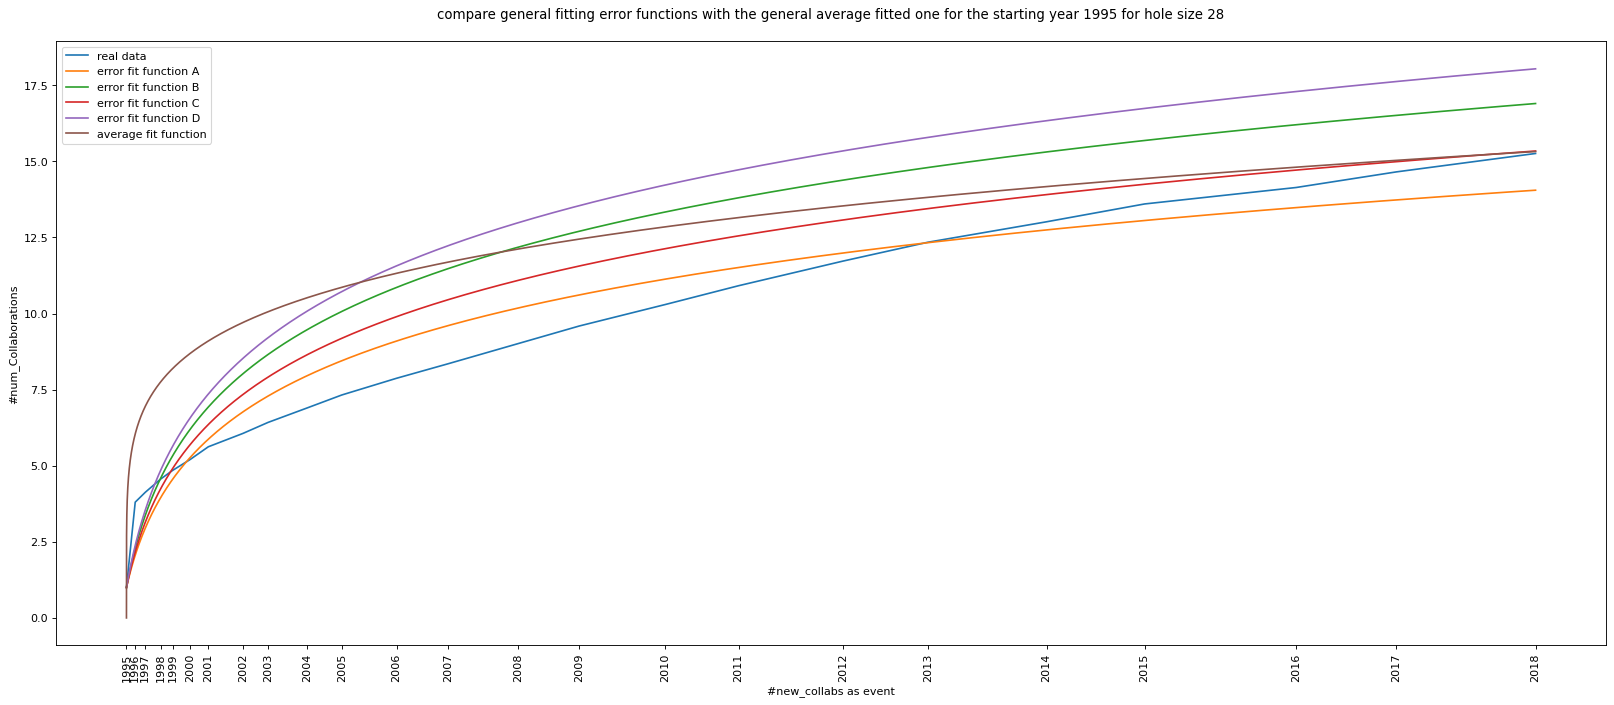

In [13]:
plot_all("1995")

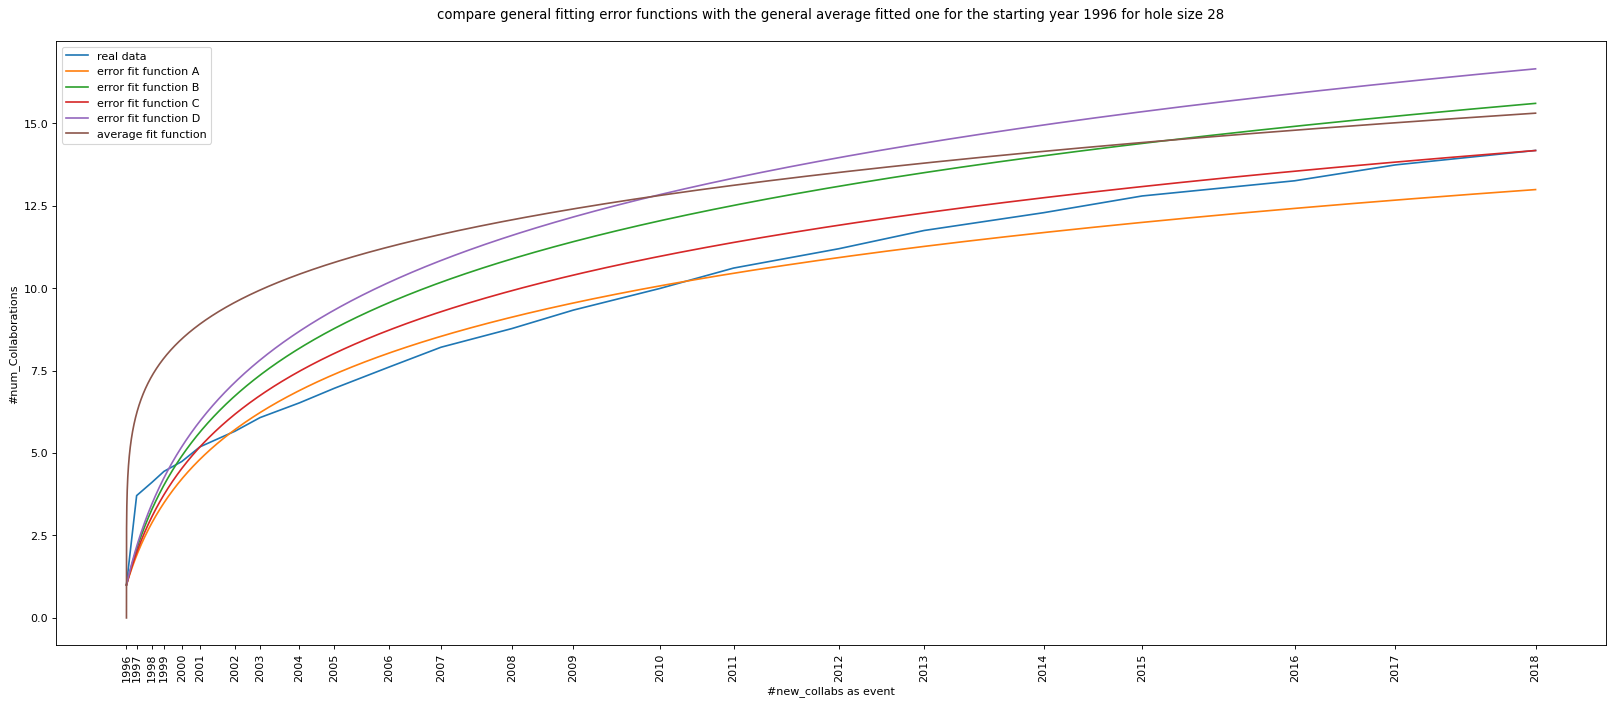

In [14]:
plot_all("1996")

In [15]:
plot_all("1997")

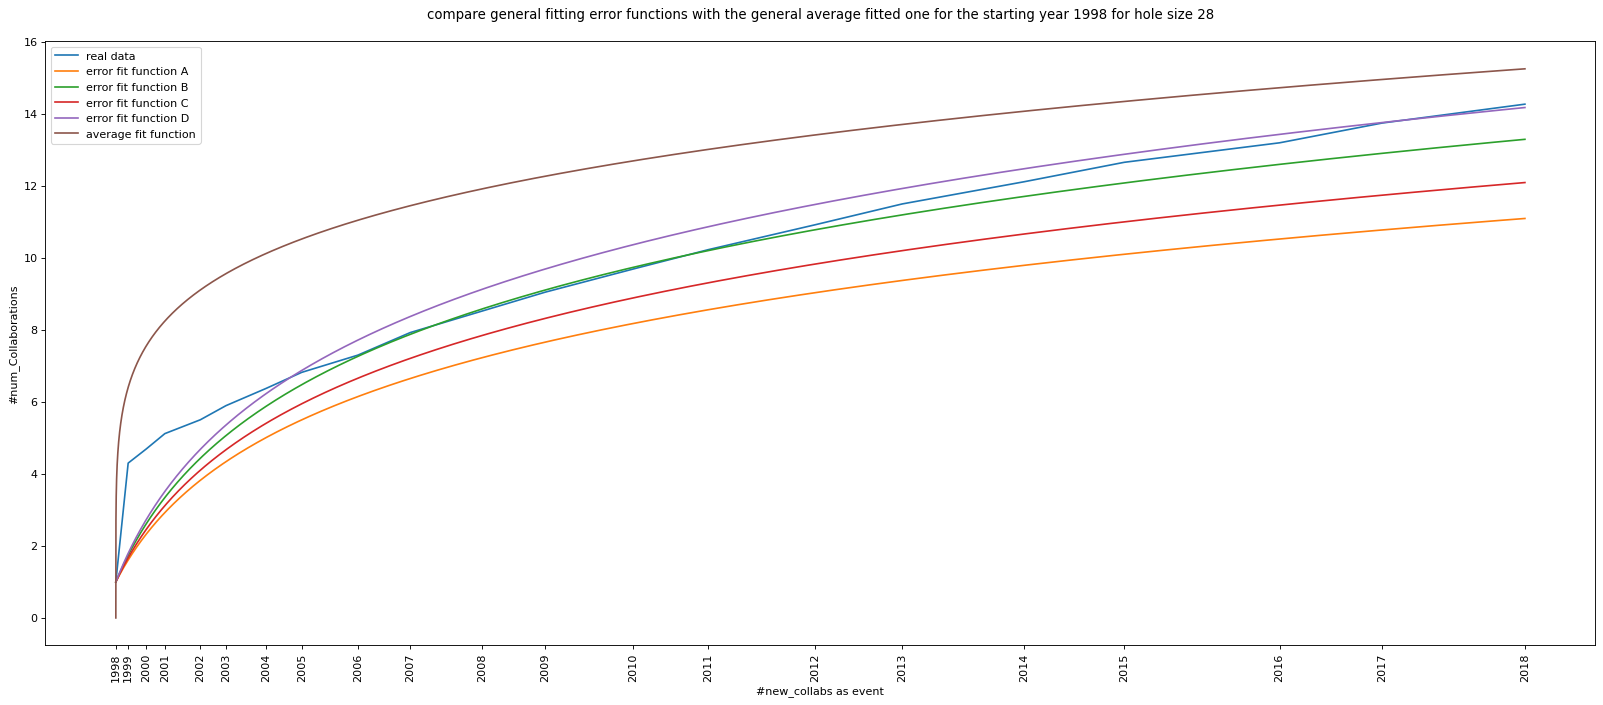

In [8]:
plot_all("1998")

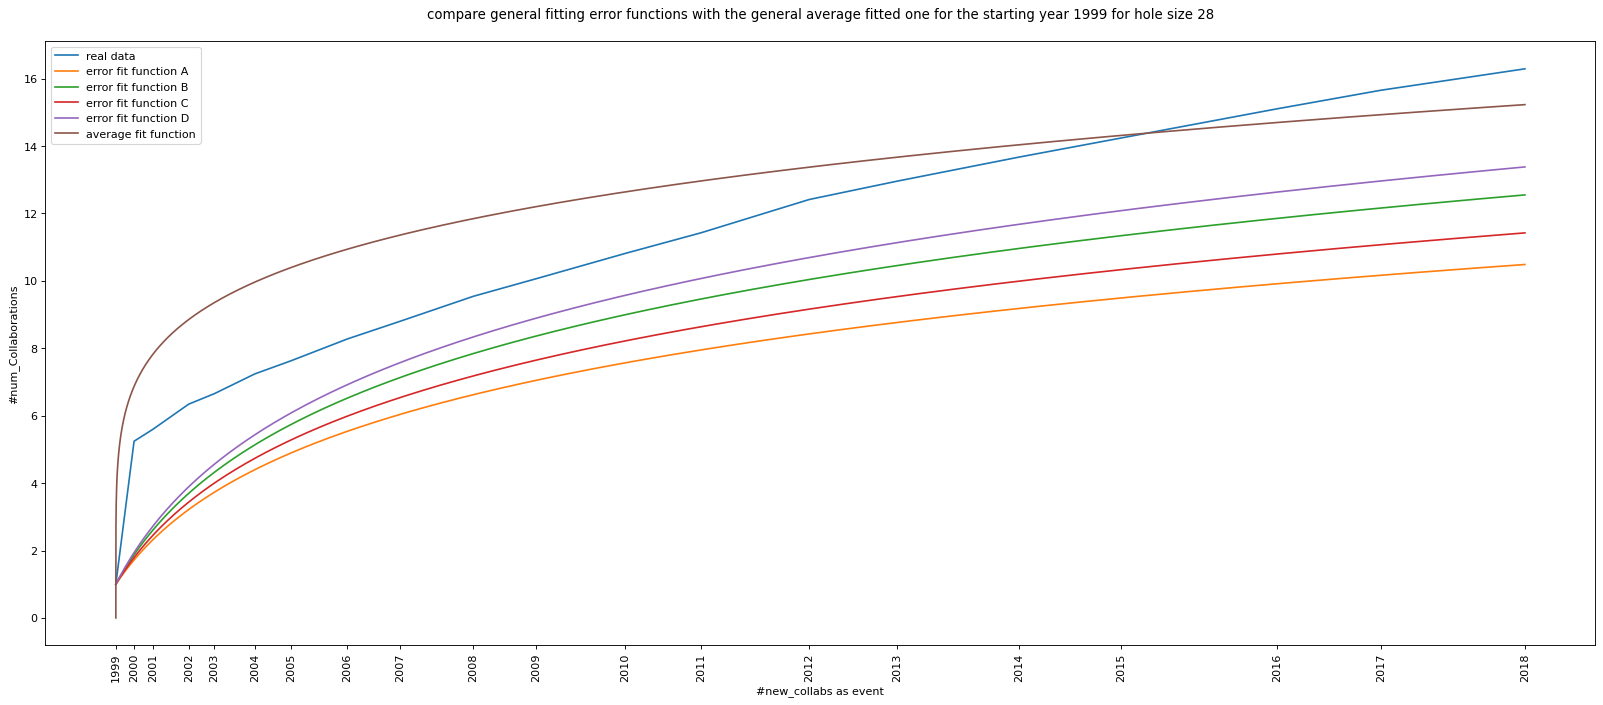

In [9]:
plot_all("1999")

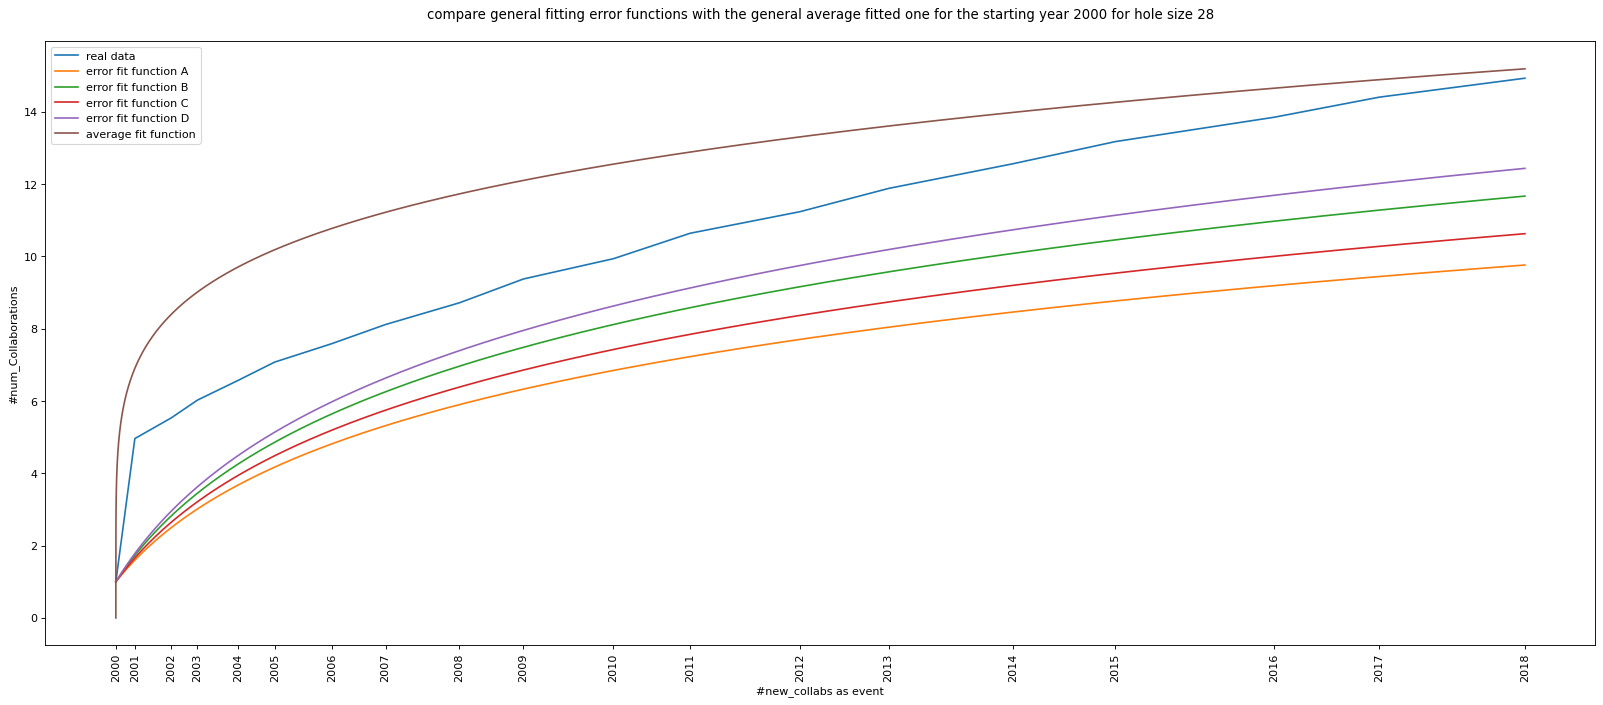

In [10]:
plot_all("2000")

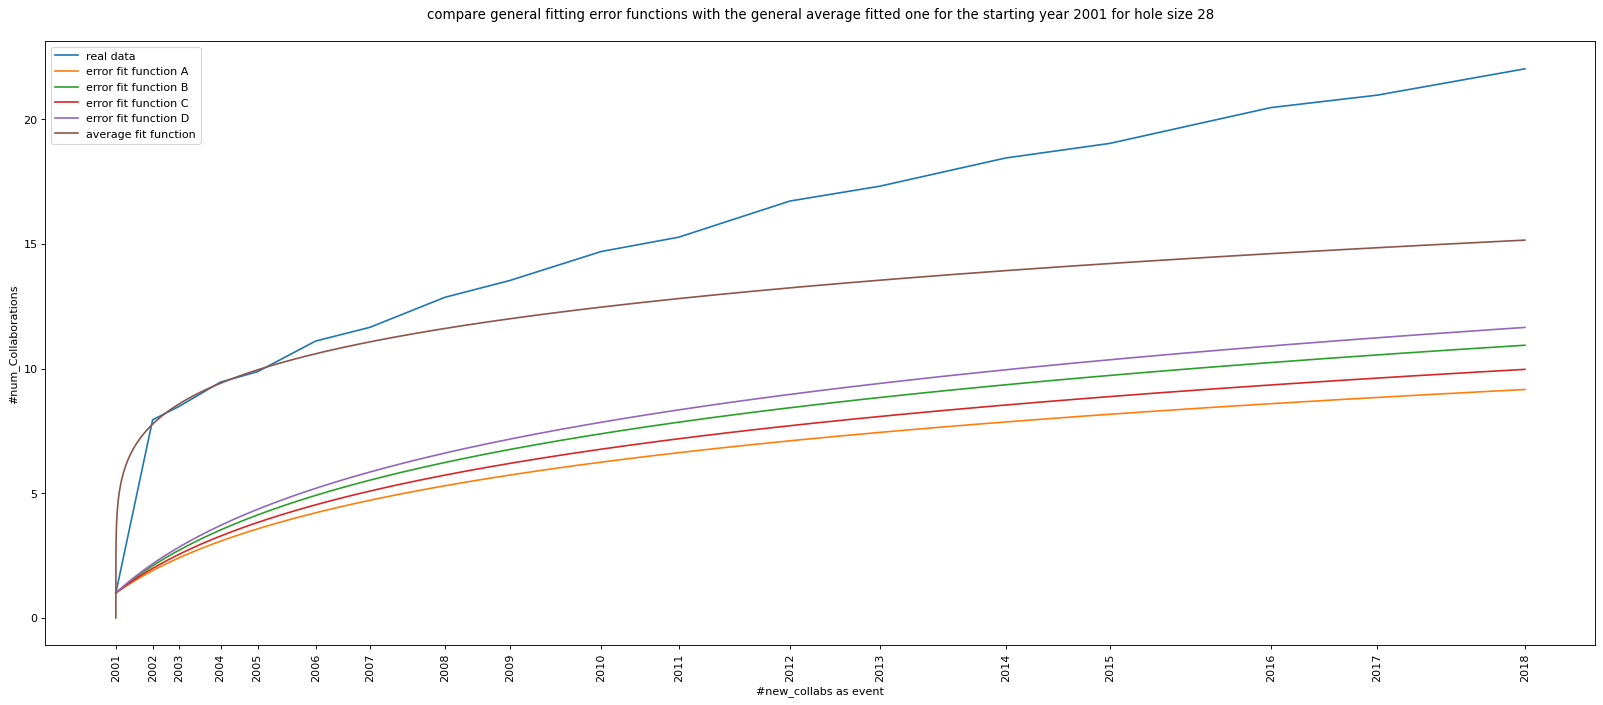

In [11]:
plot_all("2001")

In [12]:
plot_all("2002")

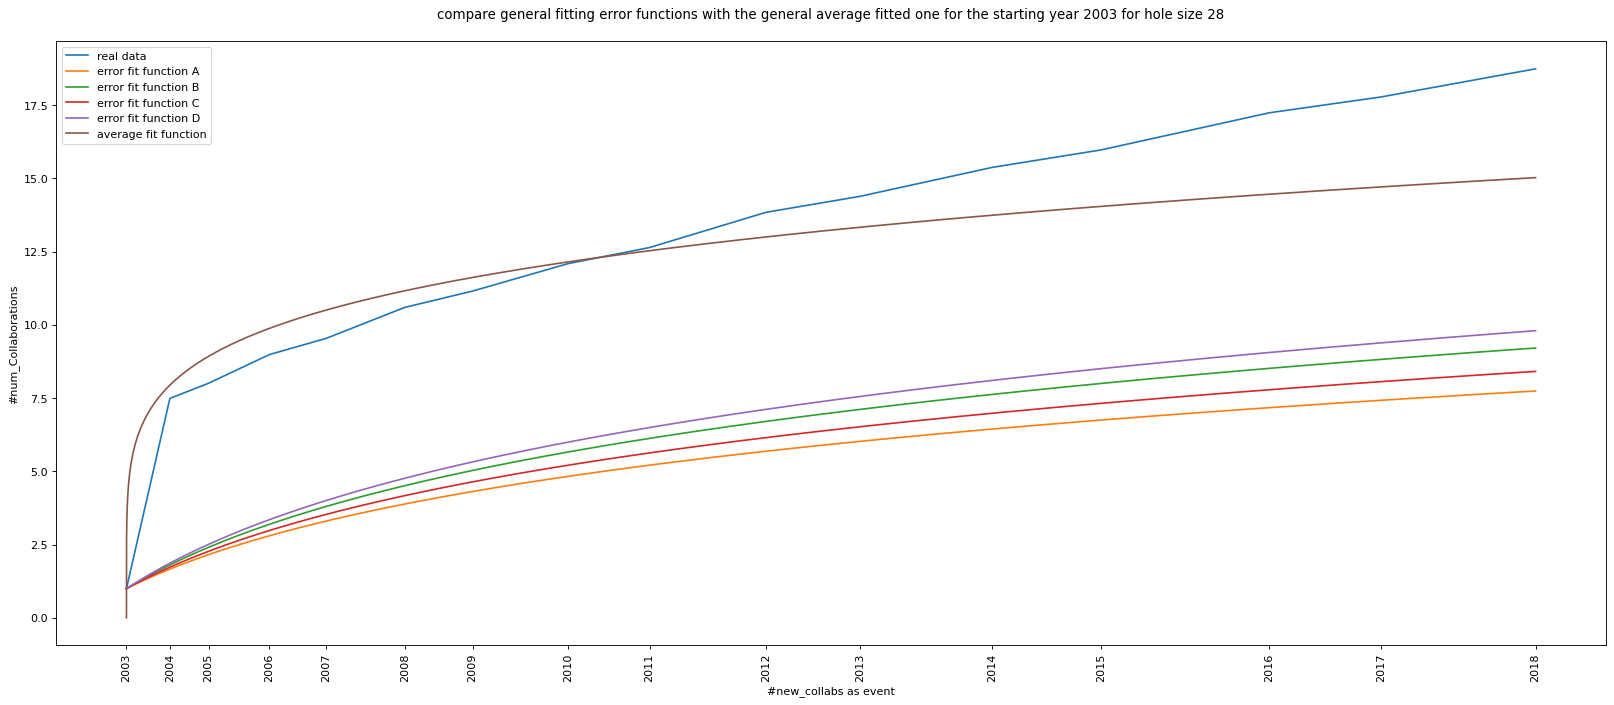

In [13]:
plot_all("2003")

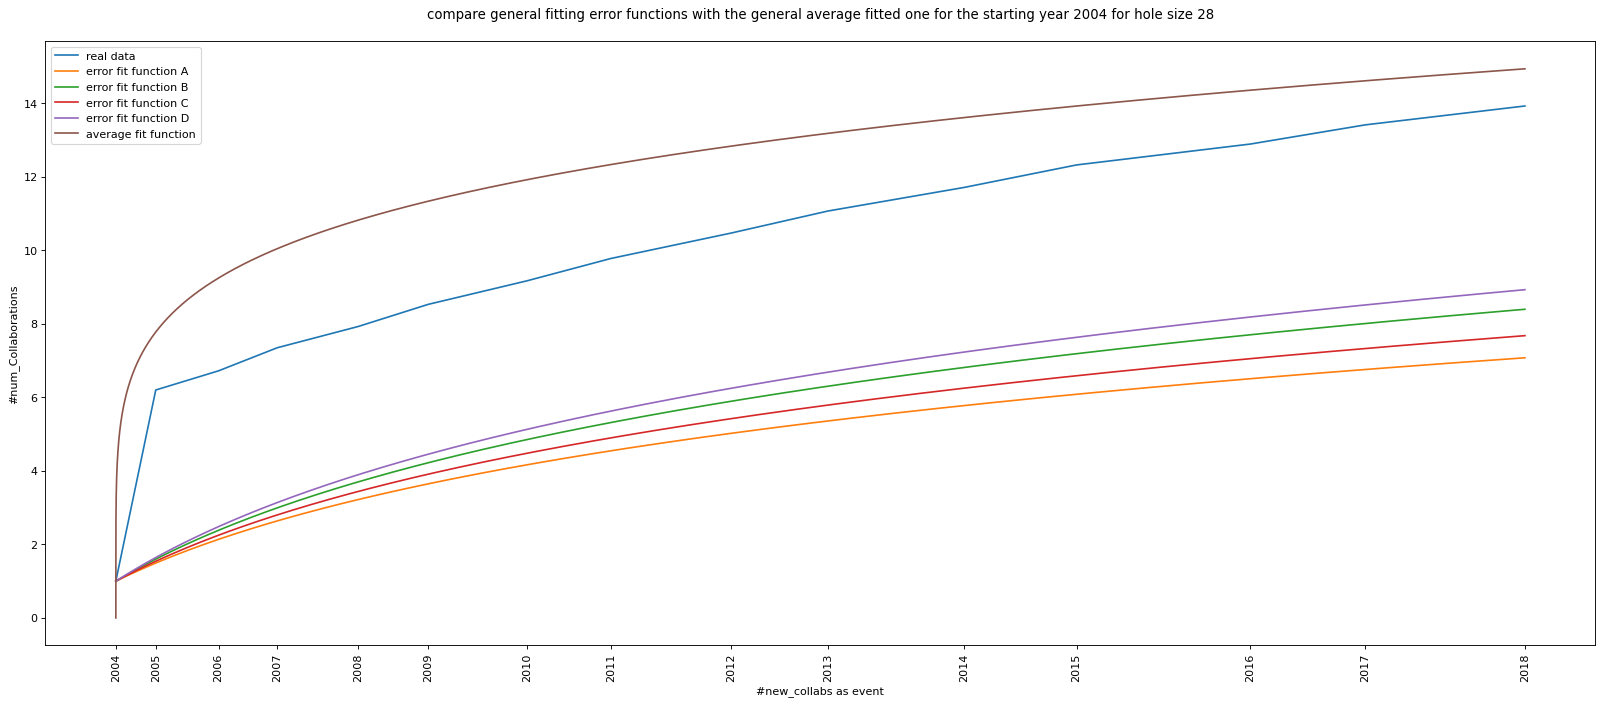

In [14]:
plot_all("2004")

In [15]:
plot_all("2005")

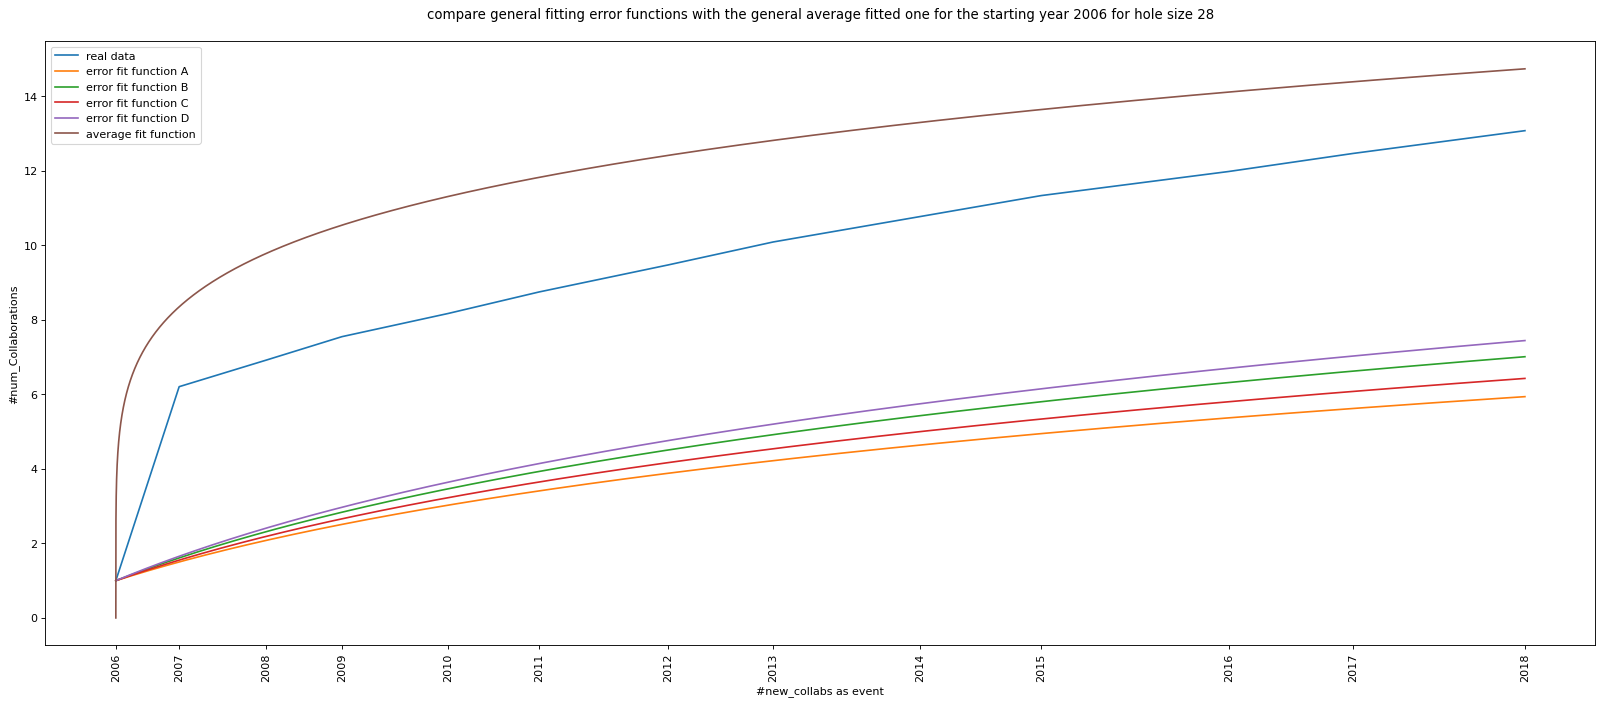

In [8]:
plot_all("2006")

In [9]:
plot_all("2007")

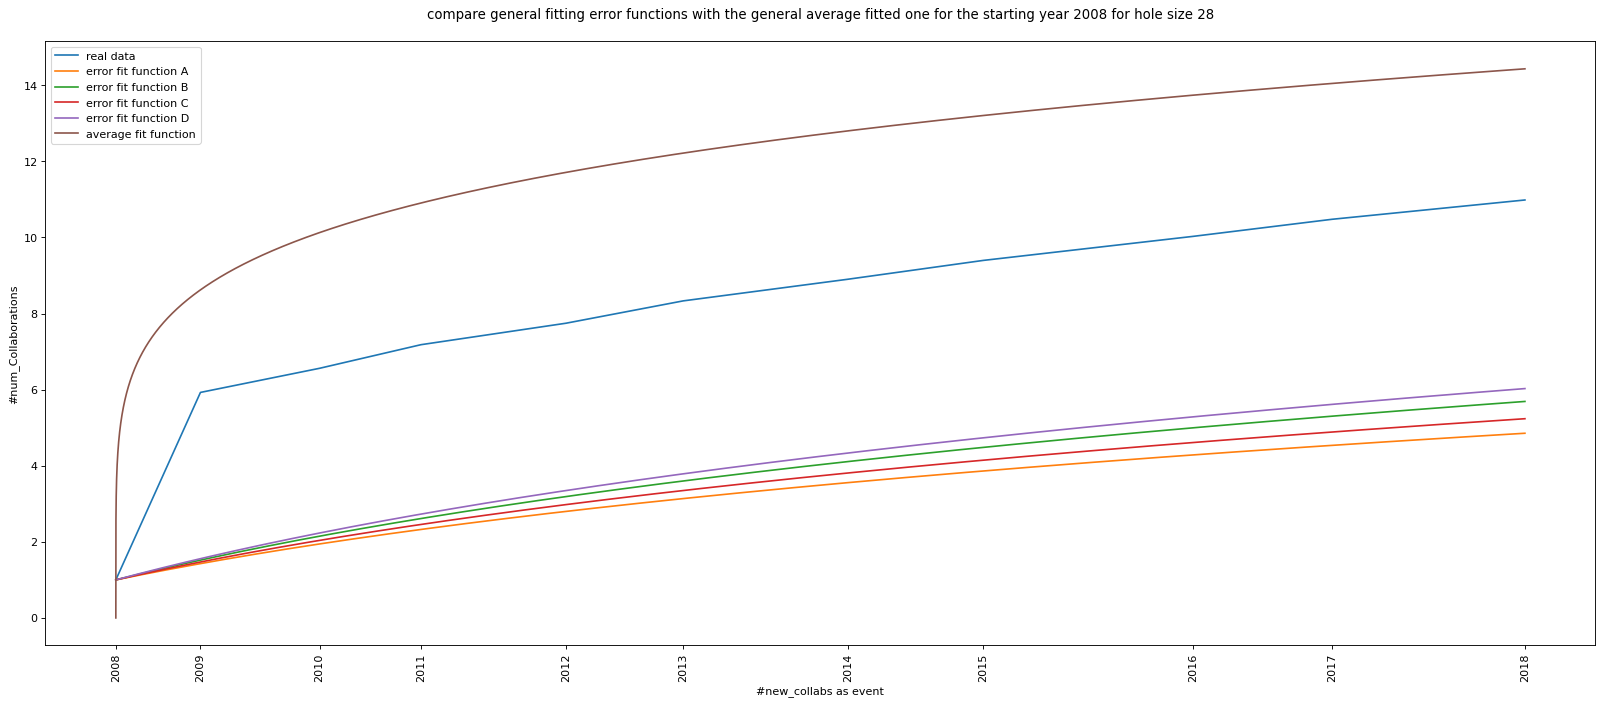

In [10]:
plot_all("2008")

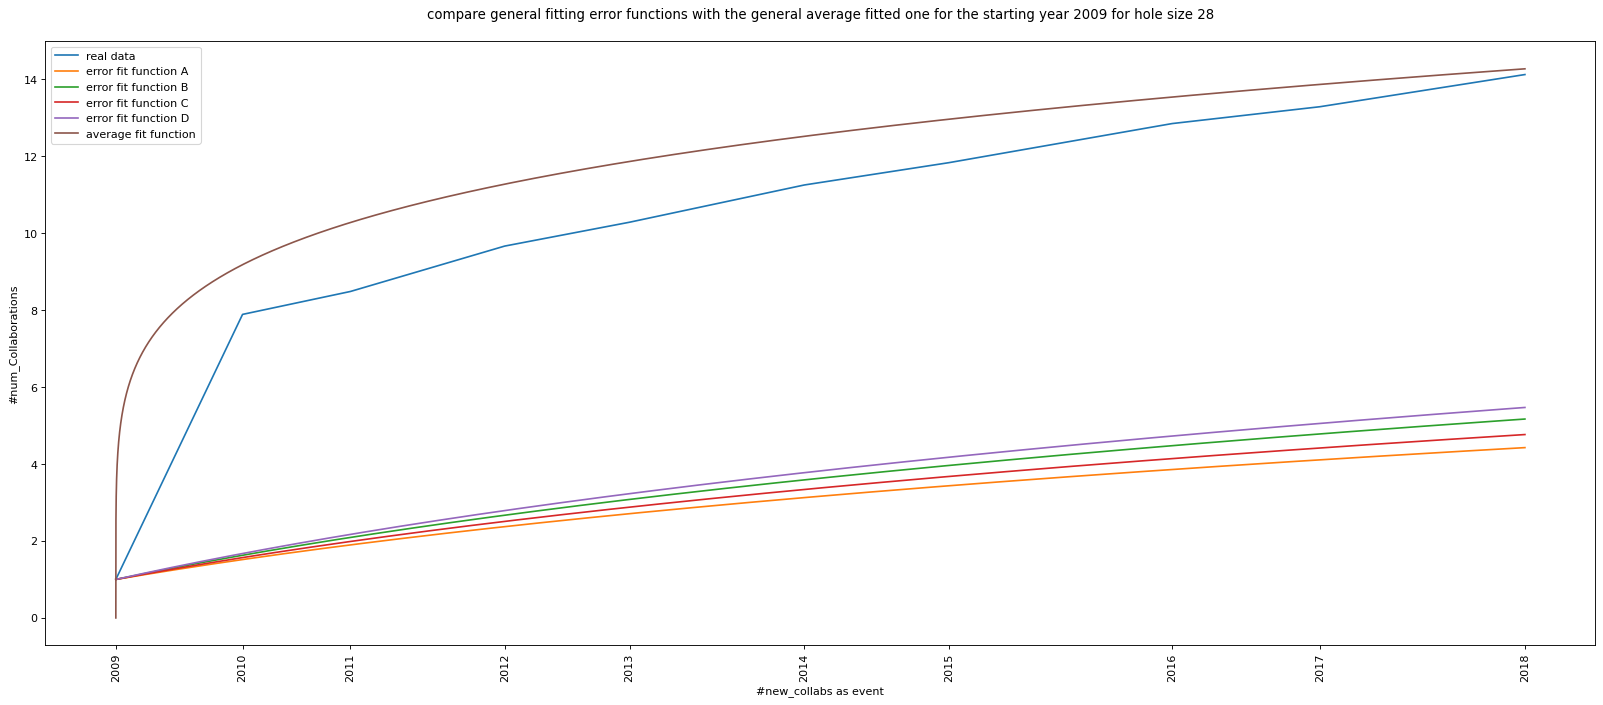

In [11]:
plot_all("2009")

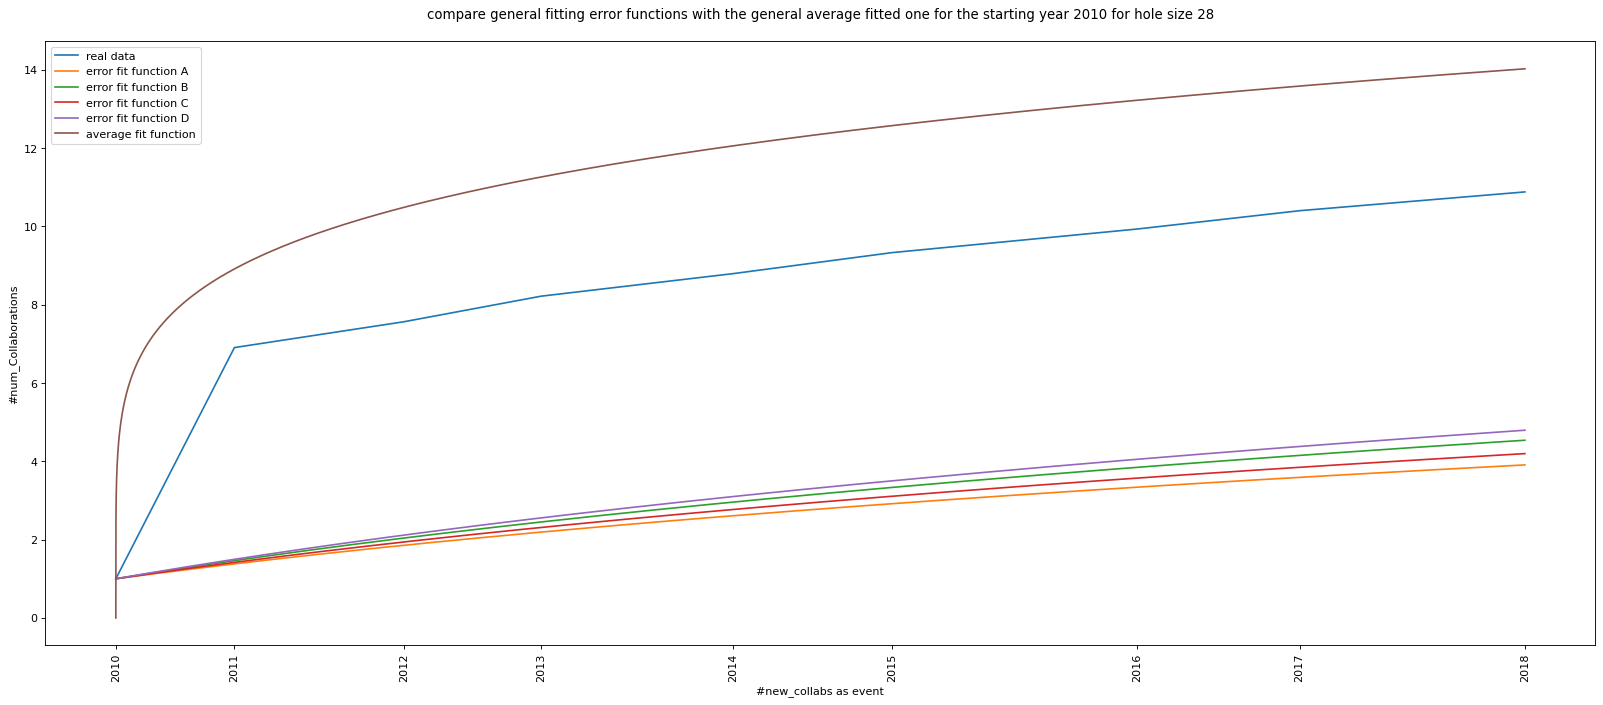

In [12]:
plot_all("2010")

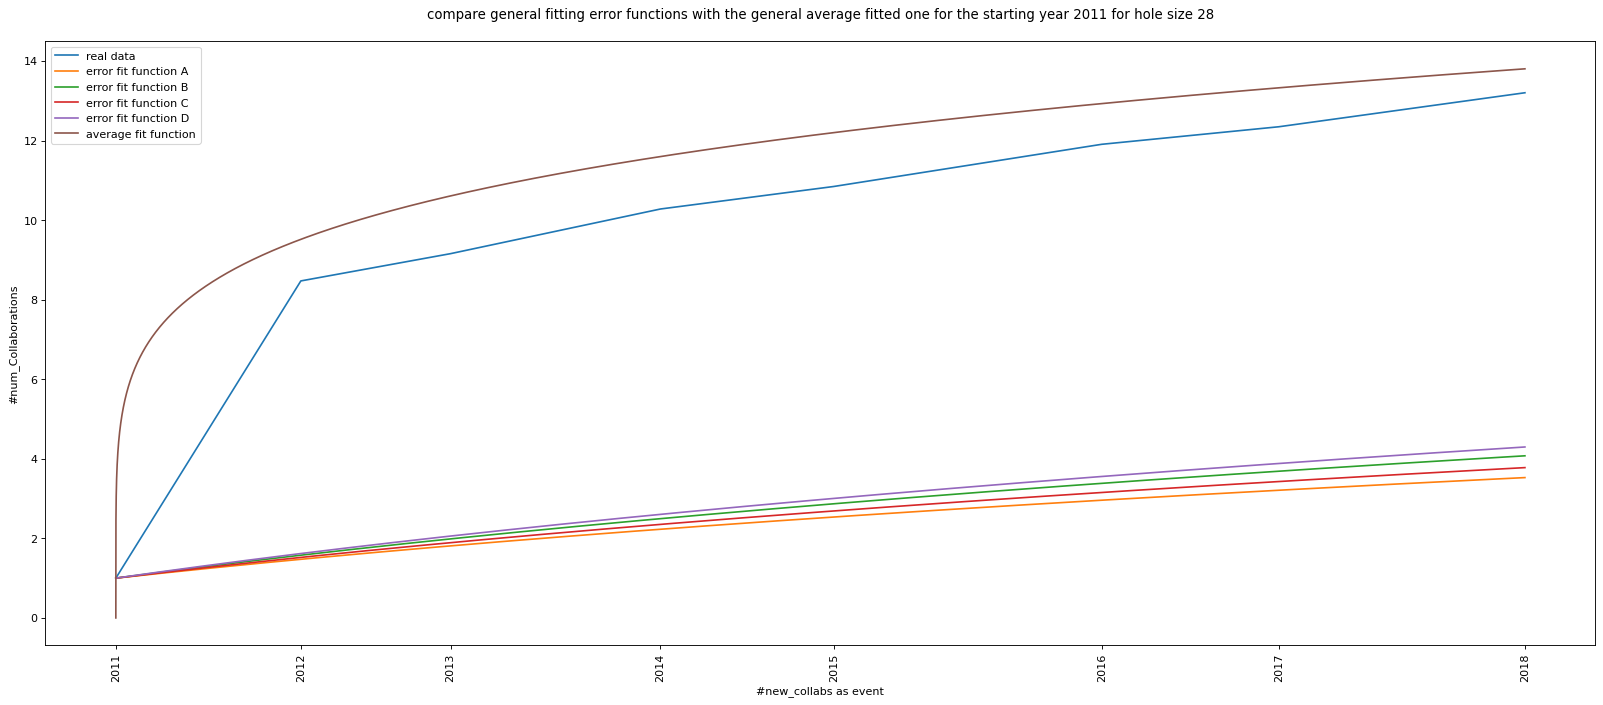

In [13]:
plot_all("2011")

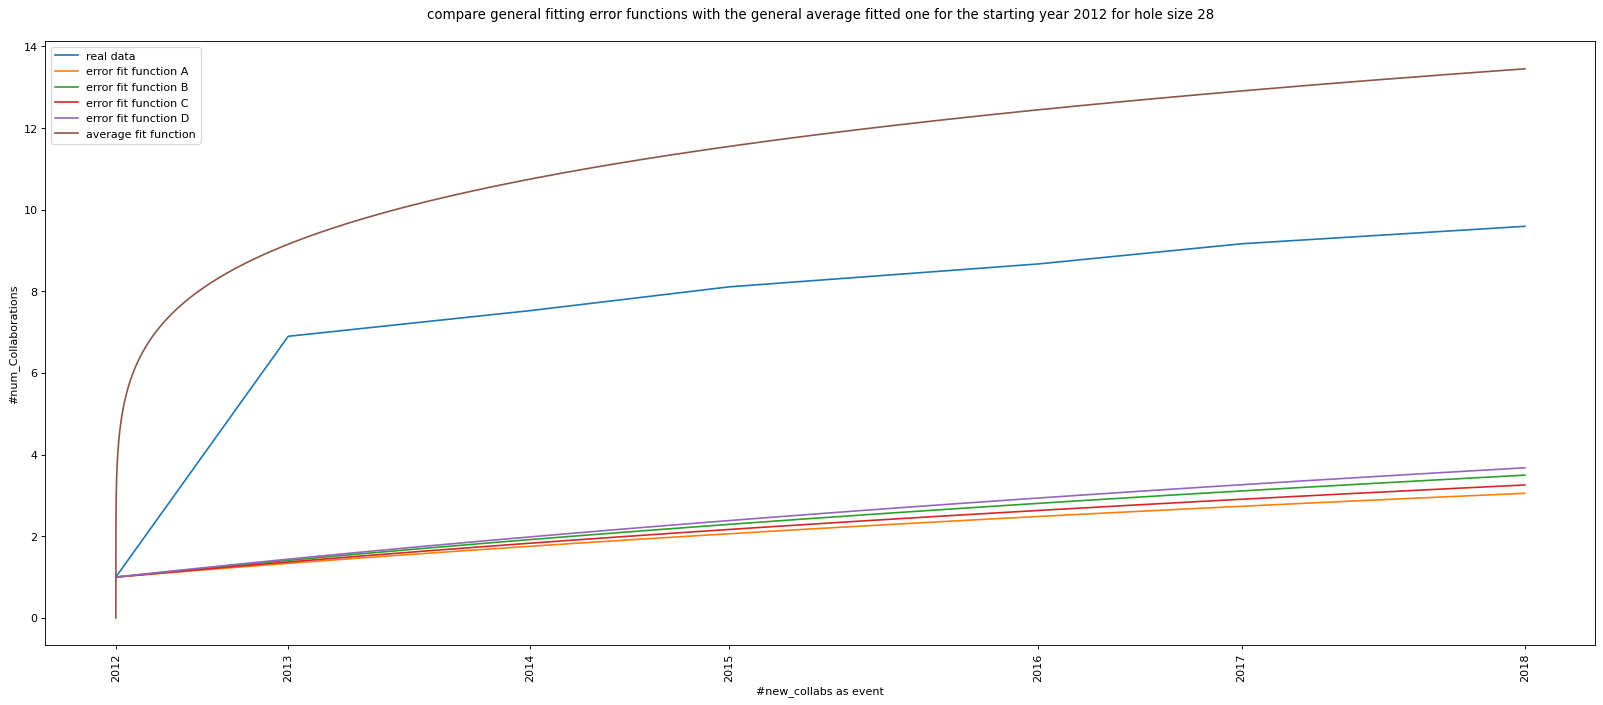

In [14]:
plot_all("2012")

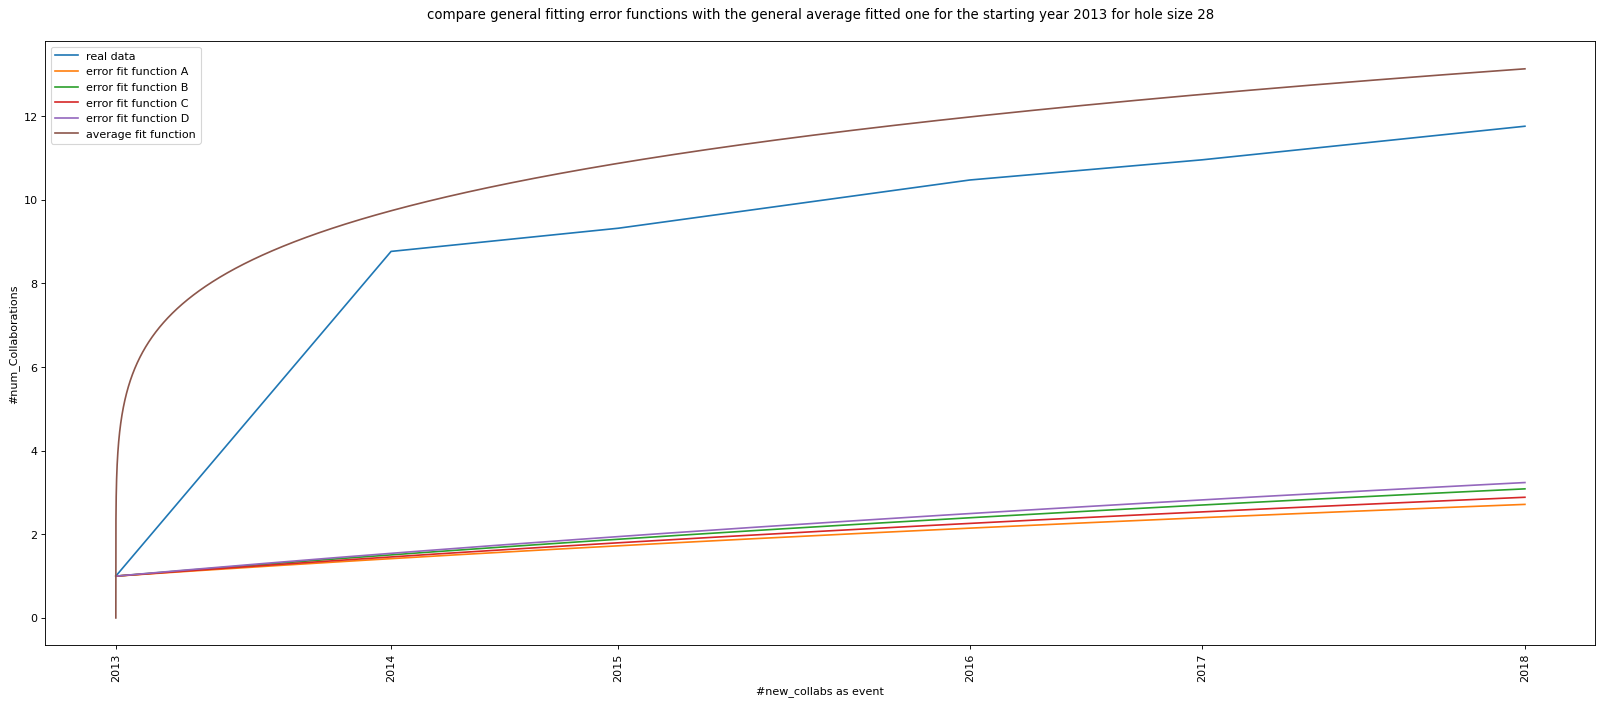

In [15]:
plot_all("2013")

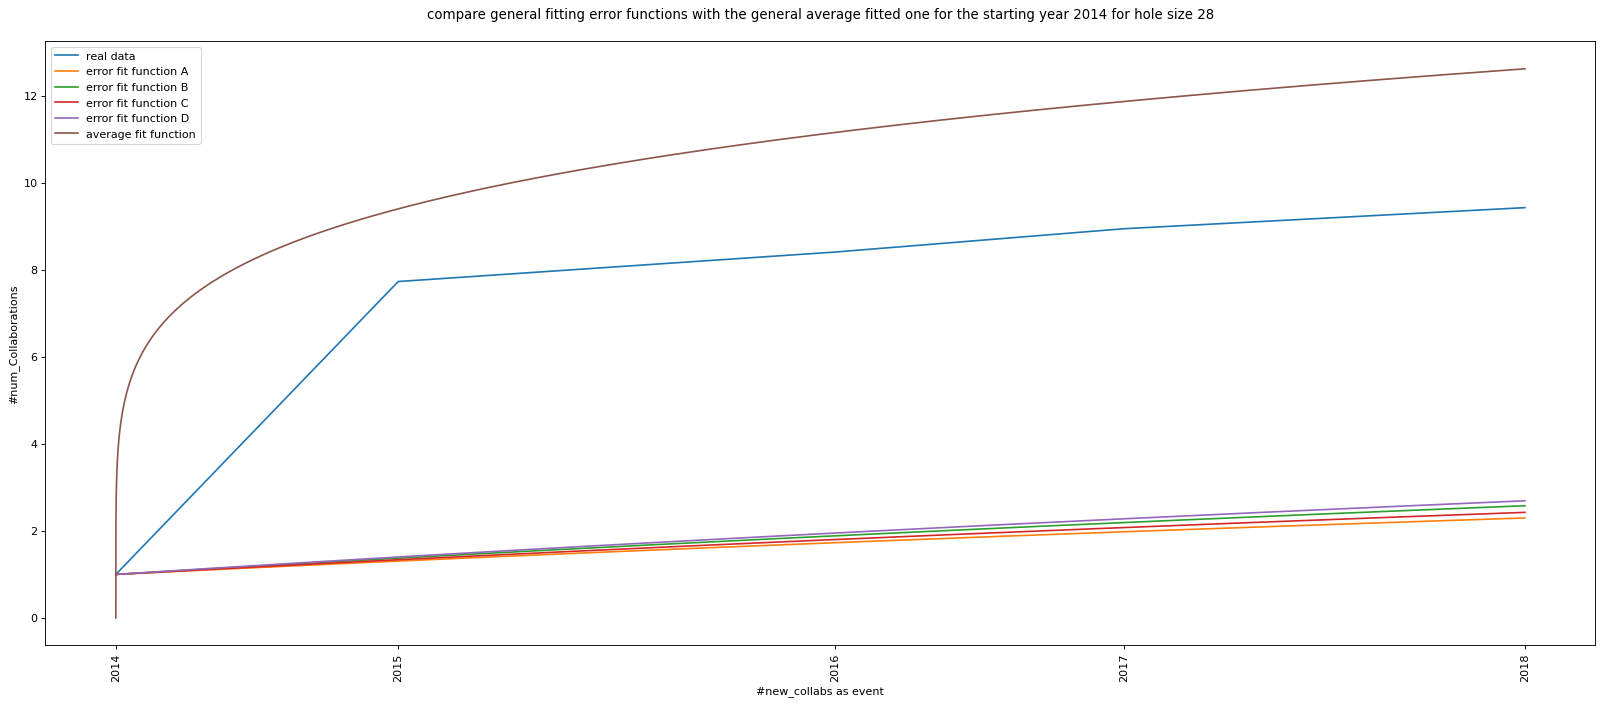

In [16]:
plot_all("2014")

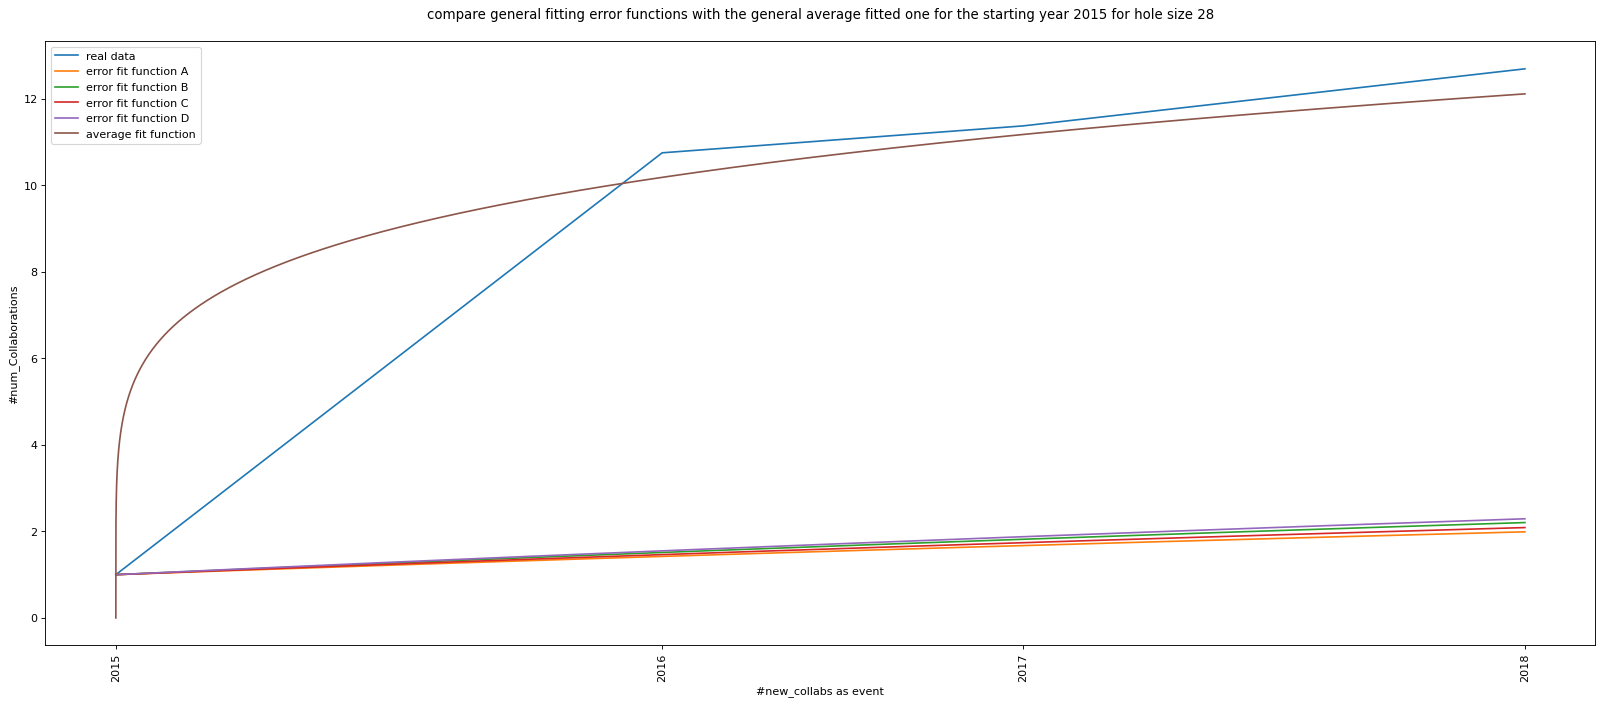

In [17]:
plot_all("2015")

In [18]:
# compute the error on real data for each error function (A,B,C,D) and the average function
avg_err = 0
A_err, B_err, C_err, D_err = 0, 0, 0, 0

for start_y in YEARS_TO_CONSIDER:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # real trajectories
    
    avg_fit = poly_theoretical_func(x, alpha, beta, np.int64(1))
    a =  poly_theoretical_func(x, alphas_opt[0], betas_opt[0], xdata[i])
    b =  poly_theoretical_func(x, alphas_opt[1], betas_opt[1], xdata[i])
    c =  poly_theoretical_func(x, alphas_opt[2], betas_opt[2], xdata[i])
    d =  poly_theoretical_func(x, alphas_opt[3], betas_opt[3], xdata[i])

    for i in range(len(x)):
        avg_err += abs(y[i] - avg_fit[i])
        A_err += abs(y[i] - a[i])
        B_err += abs(y[i] - b[i])
        C_err += abs(y[i] - c[i])
        D_err += abs(y[i] - d[i])
    
print("errors on real data:")
print("avg_err: ", avg_err)
print("A_err: ", A_err)
print("B_err: ", B_err)
print("C_err: ", C_err)
print("D_err: ", D_err)

errors on real data:
avg_err:  1460.8149593437606
A_err:  10896.301139479978
B_err:  14094.28548839826
C_err:  12309.245584023214
D_err:  15342.005629016563
